In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from graphviz import Digraph

In [16]:
class Value:
    
    # To initialize an object with a value
    def __init__(self,data,_children=(),_op='',label=''):
        self.data=data
        self._prev=set(_children)
        self._op=_op
        self.label=label
        self._backward= lambda :None 
        # The above function does nothing. In case of leaf nodes, no need to calculate backward gradient.
        self.grad=0.0
        # We have set grad to zero initially
        # grad is the derivative of the output wrt to this object which is being created
    
    # When we print an object, __repr__ function is called which prints an object like Value(data=data)
    def __repr__(self):
        return f"Value(data={self.data})"
        
    # When 2 Value objects are added 
    def __add__(self,other):
        out=Value(self.data+other.data,(self,other),'+')
        
        def _backward():
            self.grad+=out.grad
            other.grad+=out.grad
        out._backward=_backward
        
        return out
    
    # When 2 Value objects are muiltiplied
    def __mul__(self,other):
        out=Value(self.data*other.data,(self,other),'*')
        
        def _backward():
            self.grad+=other.data*out.grad
            other.grad+=self.data*out.grad
        out._backward=_backward
        
        return out
    
    
    def tanh(self):
        n=self.data
        t=(math.exp(2*n)-1)/(math.exp(2*n)+1)
        out=Value(t,(self,),'tanh')
        
        
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        
        return out
    
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
        
        

In [5]:


def trace(root):
  # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label,n.data,n.grad), shape='record')
        if n._op:
          # if this value is a result of some operation, create an op node for it
          dot.node(name = uid + n._op, label = n._op)
          # and connect this node to it
          dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [14]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

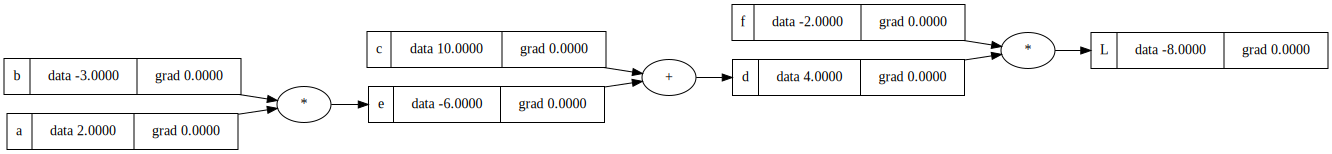

In [15]:
draw_dot(L)

In [16]:
# These obtained after manually calculating gradients of the final value wrt to each parameter

L.grad=1
d.grad=-2
f.grad=4
a.grad=-2.0*-3.0
b.grad=-2.0*2.0
e.grad=-2
c.grad=-2


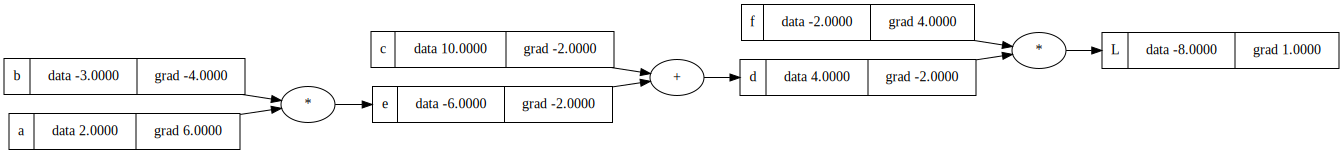

In [17]:
draw_dot(L)

In [8]:
# If we want to increase the final value i.e L by a small amount, we will increase value of intermediate parameters by a small amount in direction of gradient
# This is an example of one optimising step

a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


## One more example of testing out manual backprop

In [12]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

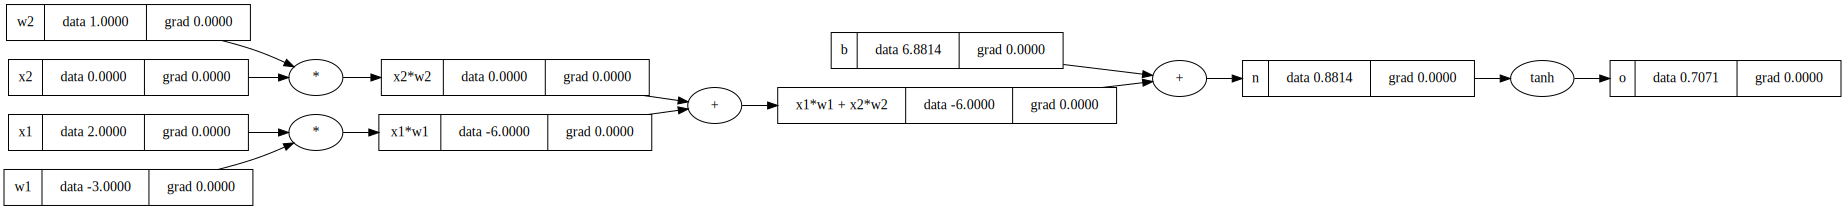

In [13]:
# Representation of one neuron with weights and activation function
draw_dot(o)

In [14]:
# Obtained after manually doing backprop 
o.grad = 1.0
# To calculate derivative wrt to n, we have exp do/dn = 1-tanh(n)**2
n.grad = 0.5  
x1w1x2w2.grad = 0.5
b.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

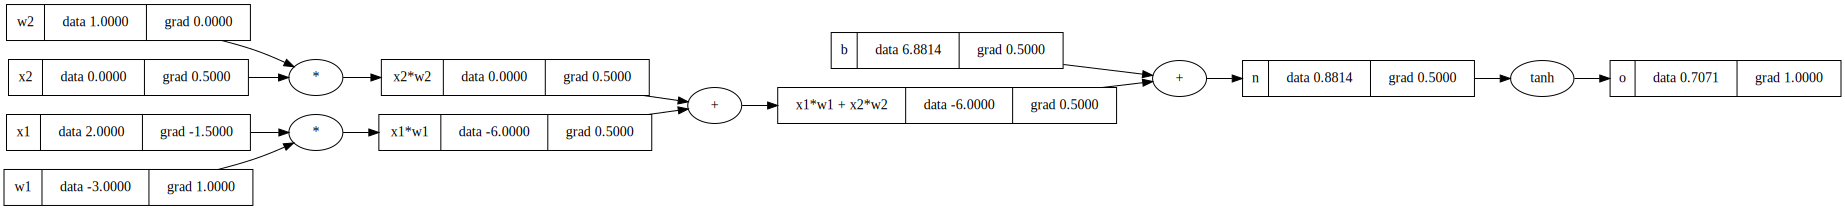

In [15]:
draw_dot(o)

## After using the _backward functionality we added for the above example. In the above cells, we were calculating gradients manually but below, we have added functionality to calculate gradients in our Value class.

In [17]:
o.grad=1

In [18]:
o._backward()

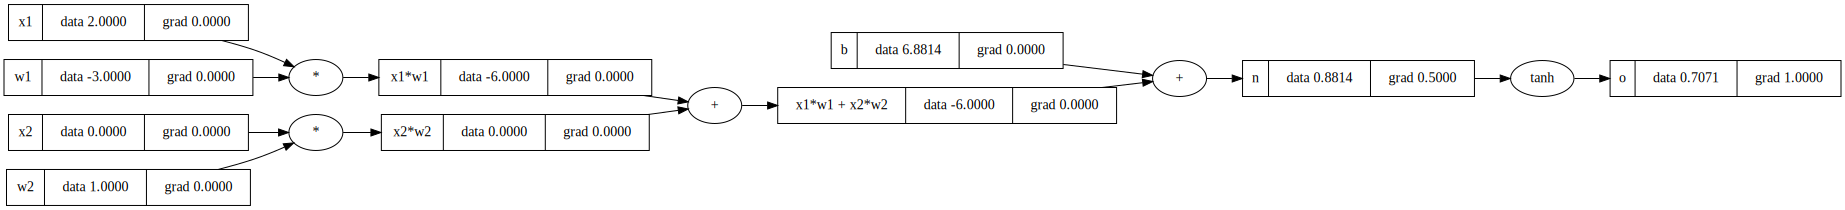

In [19]:
draw_dot(o)

In [20]:
n._backward()

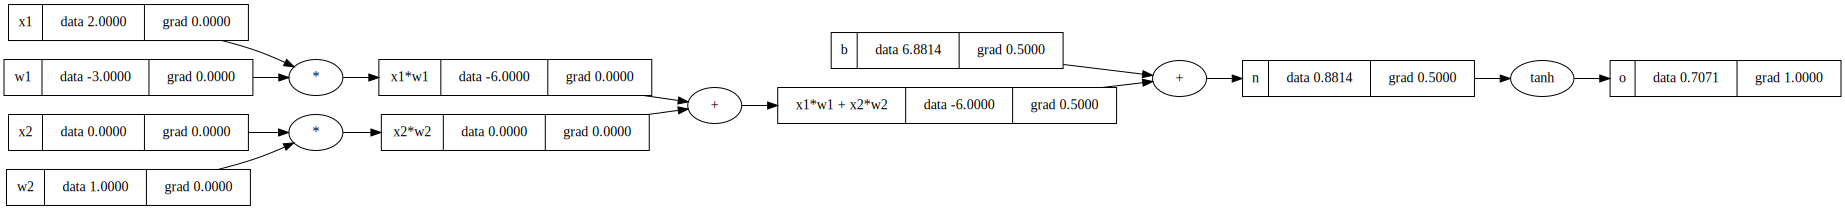

In [21]:
draw_dot(o)

In [22]:
x1w1x2w2._backward()

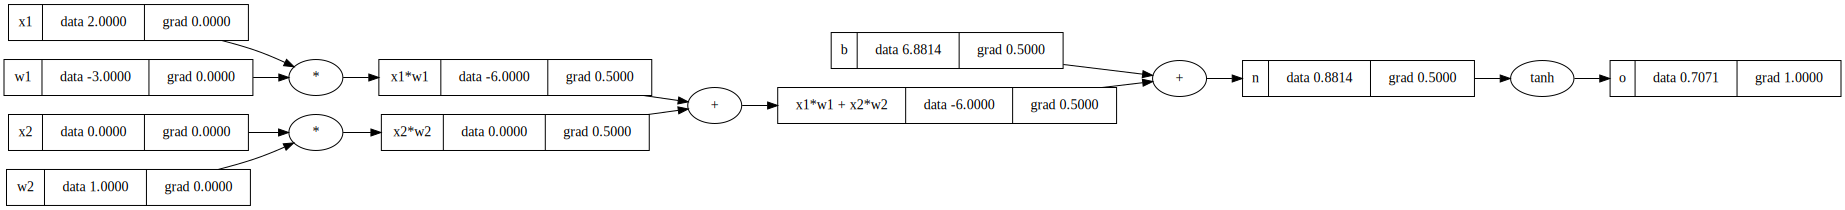

In [23]:
draw_dot(o)

In [24]:
x2w2._backward()
x1w1._backward()

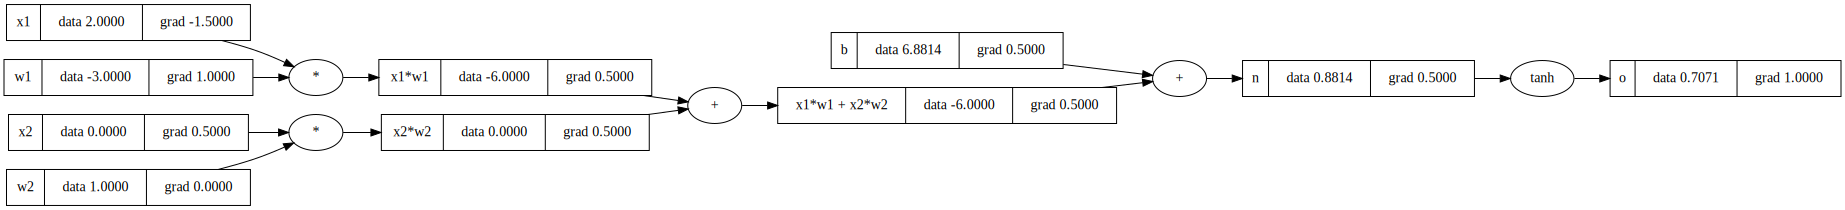

In [25]:
draw_dot(o)

## We have been calling _backward() function manually, we would like to automate it. Below, we automate this process using topological sort algorithm

In [9]:
o.grad=1
topo = []
visited = set()
def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
              build_topo(child)
        topo.append(v)
        print(v.label)
build_topo(o)

for node in reversed(topo):
    node._backward()


w2
x2
x2*w2
x1
w1
x1*w1
x1*w1 + x2*w2
b
n
o


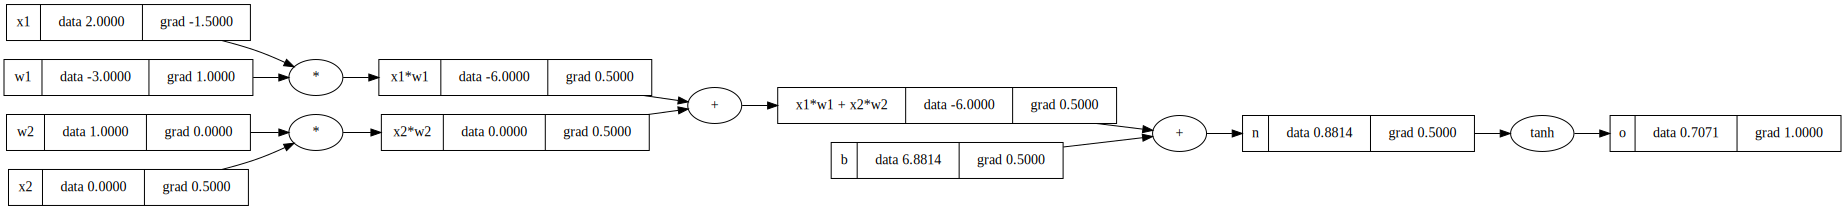

In [10]:
draw_dot(o)

## We will put the above code inside our Value class to for automating the process of calculating the gradients. We will define a function backwards() which will contain this logic

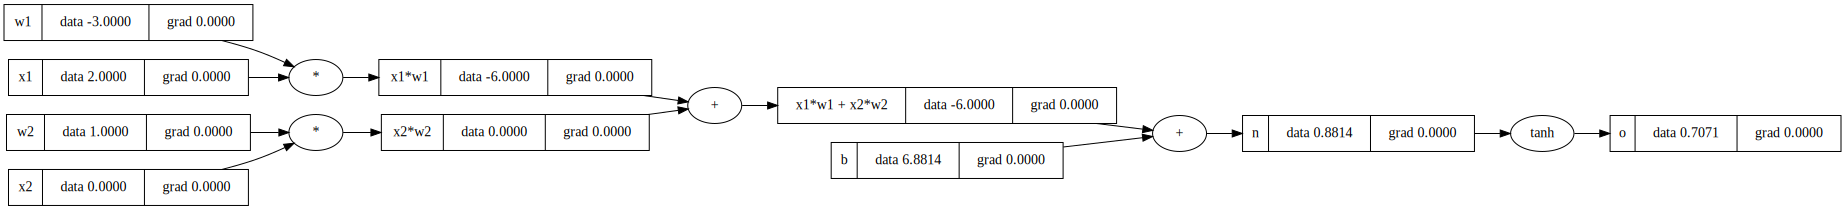

In [13]:
draw_dot(o)

In [14]:
o.backward()

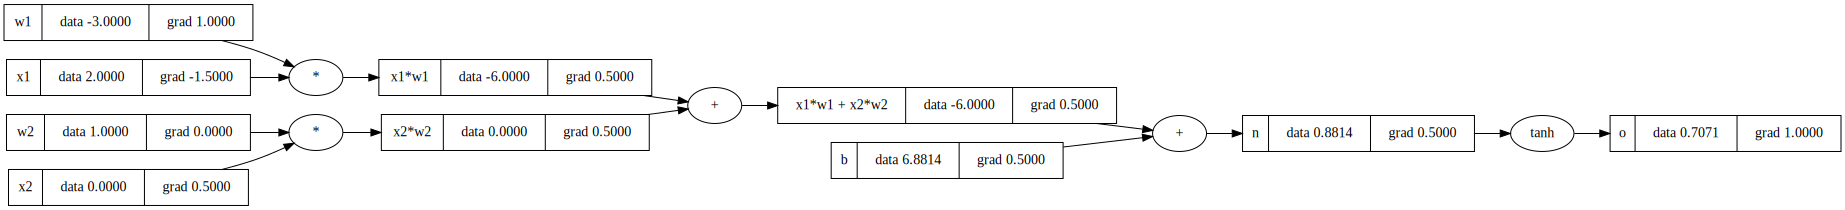

In [15]:
draw_dot(o)

## One more example to show that we have covered all the edge cases

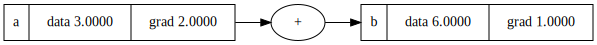

In [18]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)